# Clustering

1. Clustering 4.2.1.1: Time series kmeans
2. Clustering 4.2.1.2: Time series kmeans on aggregated dep dates per 2 based on "weeks in advance"
3. Clustering 4.2.2.1: Curve characteristics

In [1]:
#General processing and visualization 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#For the clustering 
from tslearn.clustering import TimeSeriesKMeans
from scipy.stats import skew
from scipy.stats import kurtosis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm


#For evaluation and understanding of the clustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score
from itertools import combinations
from sklearn.preprocessing import LabelEncoder

#Set the style of the visualizations
plt.style.use("seaborn")

#Ignore some warnings for readability
import warnings
warnings.filterwarnings('ignore')

## Data preparation 

In [2]:
#Import the data
file_path = r"C:\Users\annie\Desktop\uni\thesis\Untitled Folder\Bookings_Sunweb_Sun_NL.csv" #replace with your own
data = pd.read_csv(file_path, delimiter=";")

#Remove data when no destination airport is given
data = data[data["DestinationAirport"]!="0"] 

# Make two distinct columns for departure and booking : week and year e.g. DepartureYear, DepartureWeek
data[['DepartureYear', 'DepartureWeek']] = data["DepartureYearWeek"].str.split('_', expand=True).apply(pd.to_numeric)
data[['BookingYear', 'BookingWeek']] = data["BookingYearWeek"].str.split('_', expand=True).apply(pd.to_numeric)

# Compute total passengers per holiday package and add columnn "Pax_total"
data = data.merge(
    data.groupby(["DestinationAirport", "DepartureYearWeek"], as_index=False)['Pax'].sum().rename(columns={'Pax': 'Pax_total'}),
    on=["DestinationAirport", "DepartureYearWeek"]
)

#Remove all holiday packages departing on the 53rd week of any year (Note:2015 was a leap year)
data = data[~(data["DepartureWeek"] == 53)]

#Remove all bookings made in the 53rd week of any year 
data = data[~(data["BookingWeek"] == 53)]

#Create percent column : representing the percent of bookings made in a specific booking week for each holiday package
data['percent'] = data['Pax'] / data["Pax_total"]

def calculate_weeks_in_advance(row):
    '''
    Given a row, calculate how many weeks in advance of the departure week was that booking made. 
    Parameters:
    - row : one row of the dataframe
    Returns :
    - number that represents the weeks in advance 
    '''
    # If the booking and departure are in the same year, simply subtract the booking week from the departure week
    if row["DepartureYear"] == row["BookingYear"]:
        return row["DepartureWeek"] - row["BookingWeek"]
    else:
        # If the booking and departure span different years, calculate the weeks in advance by accounting for the full years and weeks difference
        return (row["DepartureYear"] - row["BookingYear"]) * 52 - (row["BookingWeek"] - row["DepartureWeek"])

# Apply the function calculate_weeks_in_advance to create a new column 'advance' representing the weeks in advance 
data["advance"] = data.apply(calculate_weeks_in_advance, axis=1)


In [3]:
def make_X(data):
    '''
    Generate a DataFrame that is indexed per holiday package with the following columns:
    1. DestinationCountry: The country of the destination airport. e.g. "Spain"
    2. DestinationAirport: The code of the destination airport.  e.g. "ACE"
    3. DepartureYearWeek: The combination of the departure year and week. e.g. "2015 _ 51"
    4. DepartureYear: The year of departure. e.g. 2015
    5. DepartureWeek: The week of departure.  e.g. 51
    6. Pax_total: The total number of passengers.  e.g. 243
    7. BookingsList: An array of length 104 representing the percent of bookings made for each booking week in advance.
       E.g., at index 0: 0.0041 means 0.41% of the total bookings were made 0 weeks in advance(same week as departure).
    8. WeekList: An array of length 104 representing the booking week of the year when the booking occurred.
        E.g., at index 0: 51, the week of departure is booking week 51 , at index 1: 50 , 1 week before departure is booking week 50
        
    Note: The lists come in handy for reducing the high-dimensionality of the data instead of having one row per booking week,
    there is one row per holiday package 
    
    Parameters:
    - data: The input DataFrame containing the booking data
    Returns:
    - df: The generated DataFrame with the specified columns with the lists, indexed by each holiday package
    '''
    
    result = []

    # A unique holiday package is defined as a combination of destination airport and departure year-week
    holiday_packages = data.groupby(['DestinationAirport', 'DepartureYearWeek'])

    # Iterate through each unique holiday package
    for (destination, dep), destination_data in holiday_packages:
        # Filter the data for the current destination and departure year-week
        destination_data = data[(data['DestinationAirport'] == destination) & (data["DepartureYearWeek"] == dep)]

        week_numbers = []  # Initialize a list to hold the week numbers in descending order
        number = destination_data["DepartureWeek"].iloc[0]  # The starting point for the booking weeks is the departure week

        # Create a descending list of the booking weeks
        while len(week_numbers) < 104:  # Considering a 2-year horizon, hence 104 weeks
            week_numbers.append(number)  # Append the current number to the list
            number -= 1  # Decrement the current number to get the next week in descending order
            if number == 0:  # If the current number reaches 0, restart from week 52 (end of the year)
                number = 52

        bookings_per_week = np.zeros(104)  # Initialize an array to track bookings for the 104-week horizon, starting with zero bookings

        # Fill the bookings array with the booking percentages
        for index, row in destination_data.iterrows():
            advance = row["advance"]  # Calculate the number of weeks in advance the booking was made
            bookings_per_week[advance] = row['percent']  # Set the booking percentage for the corresponding week in advance

        # Append the results for the current holiday package to the result list
        result.append([
            row['DestinationCountry'],  # Country of the destination
            destination,  # Destination airport
            dep,  # Departure year-week
            row['DepartureYear'],  # Departure year
            row['DepartureWeek'],  # Departure week
            row['Pax_total'],  # Total number of passengers
            list(bookings_per_week),  # List of bookings per week
            week_numbers  # List of week numbers in descending order
        ])

    # Create a DataFrame from the result list with appropriate column names
    df = pd.DataFrame(result, columns=[
        'DestinationCountry', 'DestinationAirport', 'DepartureYearWeek', 
        'DepartureYear', 'DepartureWeek', 'Pax_total', 
        'BookingsList', "WeekList"
    ])

    return df

# Call the function make_X
df = make_X(data)
    
#add column of either high or low volume holiday package based on the predetermined value of 50 passengers
df["Passenger_Status"] = np.where(df["Pax_total"] >= 50, "high", "low")

# Calculate the accumulated sum in reverse chronological order (from latest to earliest)
# for each list in 'BookingsList' and assign the result to 'AccumulatedList'.
df["AccumulatedList"] = df["BookingsList"].apply(lambda x: np.cumsum(x[::-1])[::-1])

### Dataset split for training and test 

In [4]:
# X_train: all the holiday packages where the departure is between week 44, 2015 and week 44, 2018 (inclusive)
X_train = df[
    (
        ((df["DepartureYear"] > 2015) & (df["DepartureYear"] < 2018)) | 
        ((df["DepartureYear"] == 2015) & (df["DepartureWeek"] >= 44)) |
        ((df["DepartureYear"] == 2018) & (df["DepartureWeek"] <= 44))
    )
]

# Excluding holiday packages with total passengers less than or equal to 26 and exactly 354,
# based on analysis with similarity using the average curves (Figure 4.2)
X_train = X_train[~X_train["Pax_total"].isin(list(range(1, 27)) + [354])]

## Clustering

- Optimize parameters based on mazimizing silhouette scores and plot silhouette score, Davies-Bouldin Index, and inertia graphs for each combination
- Plot all the booking patterns per cluster along with the medoid curve
- Plot the medoid curves of each clustering

In [5]:
def cluster(X_series):
    '''
    This function performs hyperparameter tuning for the TS k-means algorithm, based on the number of clusters
    and the distance metrics chosen to find the best combination based on maximizing the silhouette score.
    It also plots the silhouette score, Davies-Bouldin Index, and inertia graphs for each combination, for visual purposes  
   
    Steps:
    1. Initialize best silhouette score and best parameters.
    2. Define parameter grids for the number of clusters and distance metrics.
    3. Initialize lists to store scores for each metric.
    4. Perform a grid search for each combination of distance metric and number of clusters.
    5. Initialize and fit the clustering model with specified parameters.
    6. Compute silhouette score, Davies-Bouldin Index, and inertia for the current model.
    7. Store the computed scores.
    8. Update best parameters if the current combination yields a better silhouette score.
    9. Plot the scores for different metrics and number of clusters.
    10. Return the best parameters for clustering.
    
    Parameters:
    - X_series : a list of lists: every nested list contains the percentages of the bookings for each holiday package in the 
            104 week booking horizon 
    Returns:
    - best_params: best combination of number of clusters and distance metric chosen
    

    '''
    best_score = -1  # Initialize best silhouette score 
    best_params = {}  # Initialize best parameters

    # Define parameter grids
    n_clusters_range = range(2, 7)  # Number of clusters ranging from 2 to 6
    distance_metrics = ["dtw", "euclidean"]  # Trying different distances: dtw and euclidean distance

    # Initialize lists to store scores
    silhouette_scores = {"dtw": [], "euclidean": []}
    davies_bouldin_scores = {"dtw": [], "euclidean": []}
    inertia_scores = {"dtw": [], "euclidean": []}

    # Grid search for every unique combination of distance and number of clusters 
    for n_clusters in n_clusters_range:
        for metric in distance_metrics:
            # Initialize and fit clustering model with set maximum number of iterations, random state and will be run 3 times with different centroid seeds 
            km = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, max_iter=5, random_state=0, n_init=3)
            
            #Predict the booking patterns and store in y_pred
            y_pred = km.fit_predict(X_series)

            # Compute silhouette score
            sihlouette_score = silhouette_score(X_series, y_pred)
            # Compute Davies-Bouldin Index
            db_score = davies_bouldin_score(X_series, y_pred)
            # Compute Inertia
            inertia = km.inertia_
    

            # Store scores for each metric
            silhouette_scores[metric].append(sihlouette_score)
            davies_bouldin_scores[metric].append(db_score)
            inertia_scores[metric].append(inertia)

            # Check if current parameters give a better score based on maximizing the sihlouette scores
            # The number of clusters was set to minimum 3
            if n_clusters >= 3 and sihlouette_score > best_score:
                best_score = sihlouette_score
                best_params['n_clusters'] = n_clusters
                best_params['metric'] = metric

    # Plotting the inertia graphs, silhouette score and Davies-Bouldin Index for each combination
    plt.figure(figsize=(18, 18))
    for i, metric in enumerate(distance_metrics):
        plt.subplot(3, 3, i*3+1)
        plt.plot(n_clusters_range, inertia_scores[metric], marker='o')
        plt.title(f'Inertia ({metric.capitalize()}) vs Number of Clusters')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')

        plt.subplot(3, 3, i*3+2)
        plt.plot(n_clusters_range, silhouette_scores[metric], marker='o')
        plt.title(f'Silhouette Score ({metric.capitalize()}) vs Number of Clusters')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')

        plt.subplot(3, 3, i*3+3)
        plt.plot(n_clusters_range, davies_bouldin_scores[metric], marker='o')
        plt.title(f'Davies-Bouldin Index ({metric.capitalize()}) vs Number of Clusters')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Davies-Bouldin Index')

    plt.tight_layout()
    plt.show()

    # Return the best parameters
    return best_params

In [6]:
def find_medoid_curve(cluster_curves):
    '''
    This function finds the medoid curve of a cluster; defined as the curve with the smallest sum of distances to all the other
    curves in that cluster
    Parameters:
    - cluster_curves : all the curves that belong in that cluster
    Returns:
    - medoid_curve_index: index of the medoid curve 
    '''

    # Calculate all the pairwise distances between curves
    distances = cdist(cluster_curves, cluster_curves, metric='euclidean')
    
    # Find the index of the most medoid curve (the one with the smallest sum of distances)
    medoid_curve_index = np.argmin(distances.sum(axis=1))
    return medoid_curve_index

def plotting_clusters(df, column_cluster, title=""):
    '''
    This function plots cumulatively all the curves in each cluster along with the medoid curve based on one cluster method and returns the 
    medoid curves for each cluster label.
    
    Parameters:
    - df : the dataframe containing all the curves (list of values)
    - column_cluster : the column where the cluster label is stored based on the clustering method
    - title : the title of the returned graph 
    
    Returns:
    - medoid_curves : the medoid curves of each cluster label 
    '''
    
    #initialize the medoid_curves dictionary
    medoid_curves = {}
    colors = ['#4c72b0', '#55a868', '#c44e52']
    
    # Convert the 'BookingsList' column from the DataFrame to a list and then to a numpy array
    series_plot = np.array(df['BookingsList'].tolist())

    # Compute the cumulative sum of the reversed array for each booking series and then reverse it back
    # This effectively computes the cumulative bookings starting from the end of the booking period
    series_plot = np.array([np.cumsum(x[::-1])[::-1] for x in series_plot])

    # Determine the unique cluster labels and their count
    unique_clusters = sorted(df[column_cluster].unique())
    num_clusters = len(unique_clusters)

    # Create a figure with subplots based on the number of clusters
    fig, axes = plt.subplots(1, num_clusters, figsize=(15, 5), sharey=True)
    fig.suptitle(title, fontsize=16)
    fig.text(0.02, 0.5, 'Percentage', va='center', rotation='vertical', fontsize=12)

    # Iterate through each unique cluster label and plot the data of that cluster label
    for ax, cluster_label in zip(axes, unique_clusters):
        cluster_indices = df.index[df[column_cluster] == cluster_label]
        
        # Extract the curves belonging to the current cluster
        cluster_curves = series_plot[cluster_indices]

        # Plot all curves belonging to the current cluster in gray color
        for curve in cluster_curves:
            ax.plot(range(len(curve)), curve, color='gray', alpha=0.5)
    
        # Find and plot the medoid curve with a different color
        medoid_curve_index = find_medoid_curve(cluster_curves) #utilize function find_medoid_curve
        medoid_curve = cluster_curves[medoid_curve_index]
        medoid_color = colors[unique_clusters.index(cluster_label) % len(colors)]
        ax.plot(range(len(medoid_curve)), medoid_curve, color=medoid_color, linewidth=2)
        #save the medoid curve
        medoid_curves[cluster_label] = medoid_curve

        # Set titles and labels
        ax.set_title(f"Cluster {cluster_label+1}") 
        ax.set_xlabel("Weeks in advance")
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    
    plt.show()
    
    return medoid_curves

In [7]:
def plot_medoids(curves, title=""):
    '''
    Plot the medoid curves for each cluster.
    Parameters:
    - curves: Dictionary containing medoid curves for each cluster, keyed by cluster ID.
    - title: Optional title for the plot (default is an empty string).
    '''
    plt.figure(figsize=(11, 6))
    # Plot each medoid curve from the dictionary
    for curve_id, data in curves.items():
        sns.lineplot(data=curves[curve_id], label=f'Medoid of Cluster {curve_id + 1}')
    # Add labels for the x and y axes
    plt.xlabel("Weeks in advance")
    plt.ylabel("Percentage of Bookings")
    
    # Add a title to the plot
    plt.title(f"Medoid Curves Comparison for {title}")
    
    # Show the plot
    plt.show()

### Calculate average curves per holiday package for Clustering

In [8]:
# Use the same training set for clustering of booking patterns
# Group all distinct holiday packages by departure week and destination airport
grouped_holiday_packages = X_train.groupby(["DepartureWeek", "DestinationAirport"])

# Initialize a new DataFrame to store holiday package data
X_train_clustering = pd.DataFrame(columns=["DepartureWeek", "DestinationAirport", "DestinationCountry", "BookingsList", "WeekList"])

# Iterate over each group of holiday packages
for i, (index, group) in enumerate(grouped_holiday_packages):
    # Populate the X_train_clustering DataFrame with necessary columns
    X_train_clustering.loc[i, "DepartureWeek"] = index[0]  #same departure week 
    X_train_clustering.loc[i, "DestinationAirport"] = index[1]  #same destinationairrport
    X_train_clustering.loc[i, "DestinationCountry"] = group["DestinationCountry"].iloc[0]   #same destinationcountry
    X_train_clustering.loc[i, "WeekList"] = group["WeekList"].iloc[0]  #same weeklist (since same departure week)
    
    # Calculate average booking patterns per group: add them element-wise and divide by the number of booking patterns in group
    # Normalize them to add up to 1 to account for small errors
    bookings_list_array = np.array(group["BookingsList"].tolist())
    average_bookings = np.sum(bookings_list_array, axis=0) / len(group)
    normalized_average_bookings = average_bookings / np.sum(average_bookings)
    
    # Store normalized bookings
    X_train_clustering.loc[i, "BookingsList"] = normalized_average_bookings


In [9]:
# Convert the 'BookingsList' column from the DataFrame X_train_clustering into a numpy array : Clustering 4.2.1.1 and 4.2.2.1
X_train_clustering_array = np.array(X_train_clustering['BookingsList'].tolist())

# Convert the 'BookingsList' column from the DataFrame X_train_clustering into a numpy array : Clustering 4.2.1.2
X_train_clustering_array_per2 = np.array([np.sum(X_train_clustering_array[:, i:i+2], axis=1) for i in range(0, X_train_clustering_array.shape[1], 2)]).T

### Ts k-means (clustering 4.2.1.1)

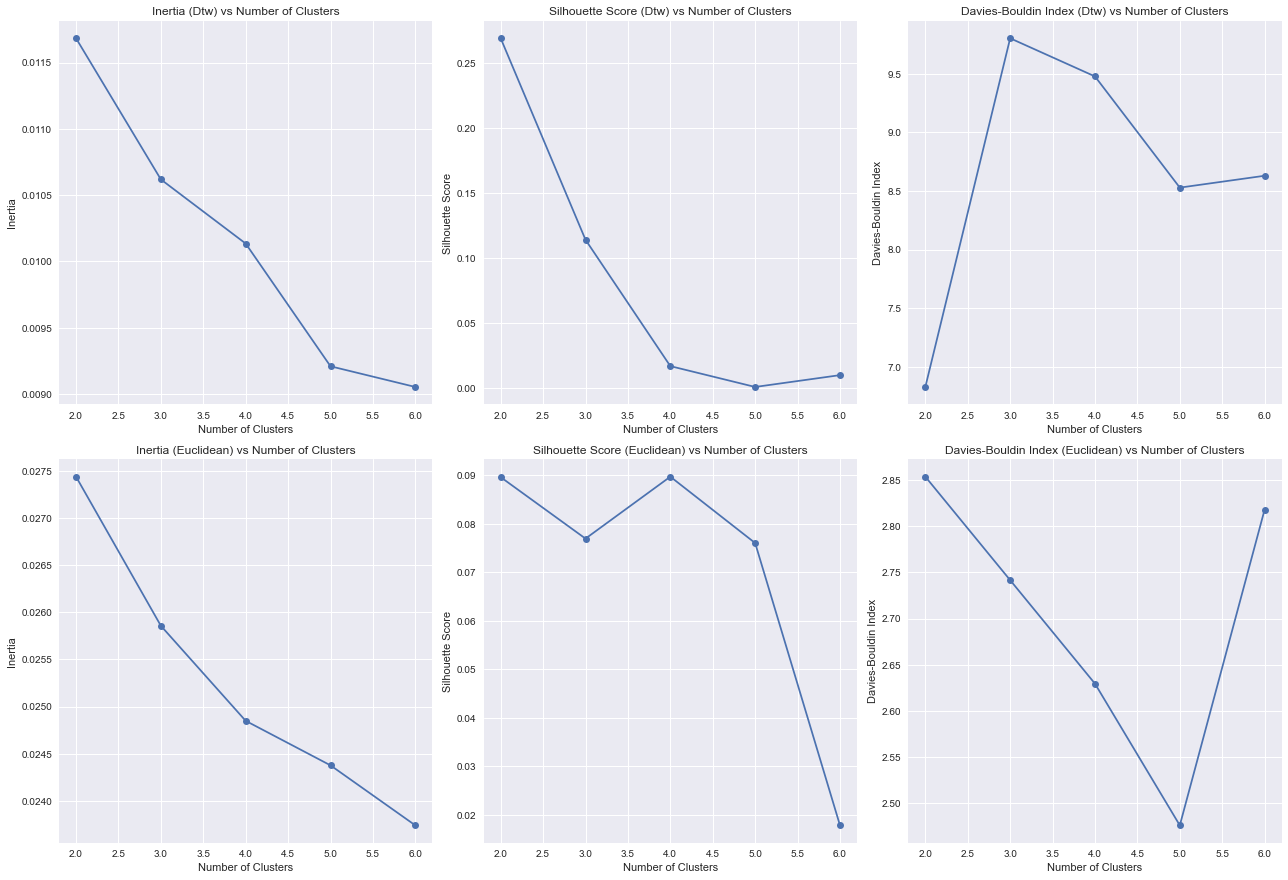

{'n_clusters': 3, 'metric': 'dtw'}


In [10]:
#Find the best parameters (choice of distance metric and number of clusters) for this clustering method
best_params = cluster(X_train_clustering_array)
print(best_params)

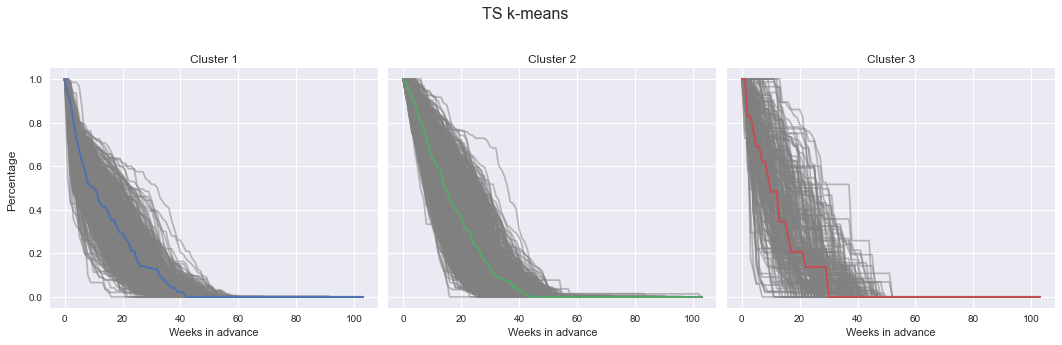

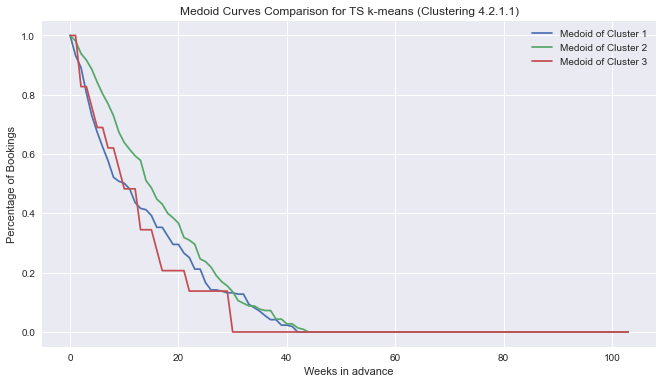

1    906
0    463
2    189
Name: Cluster_TimeSeries, dtype: int64

In [11]:
#Initialize TS k-means based on the best parameters returned
km_timeseries = TimeSeriesKMeans(n_clusters=best_params['n_clusters'], metric=best_params['metric'], max_iter=100, random_state=0, n_init=3)

#Create a new column with the cluster labels based on this clustering
X_train_clustering['Cluster_TimeSeries'] = km_timeseries.fit_predict(X_train_clustering_array)

#plot the medoids of this method
plot_medoids(plotting_clusters(X_train_clustering, 'Cluster_TimeSeries', title="TS k-means"), "TS k-means (Clustering 4.2.1.1)")

#print the value counts per cluster label 
X_train_clustering['Cluster_TimeSeries'].value_counts()

### Aggregated Ts k-means (clustering 4.2.1.2)

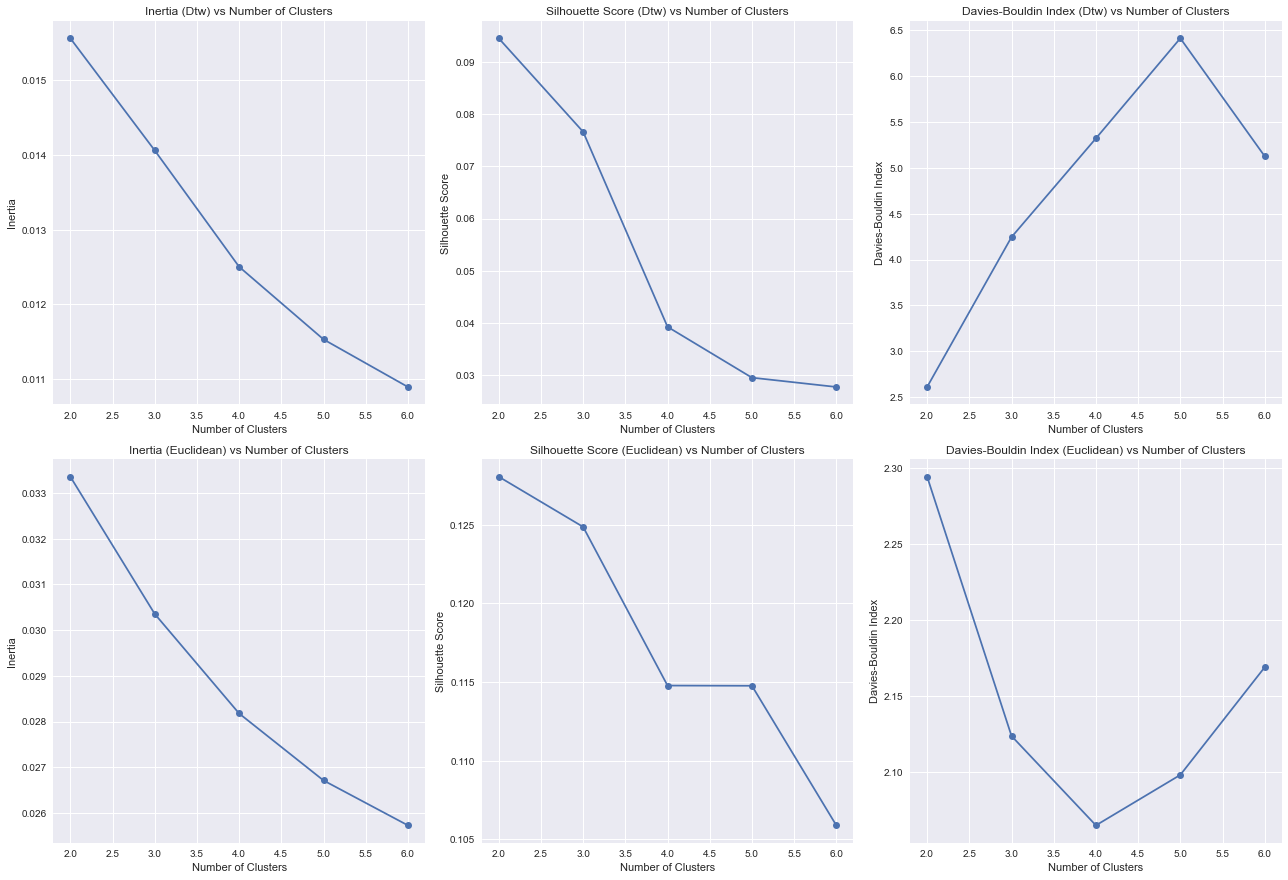

{'n_clusters': 3, 'metric': 'euclidean'}


In [12]:
#Find the best parameters (choice of distance metric and number of clusters) for this clustering method
best_params = cluster(X_train_clustering_array_per2)
print(best_params)

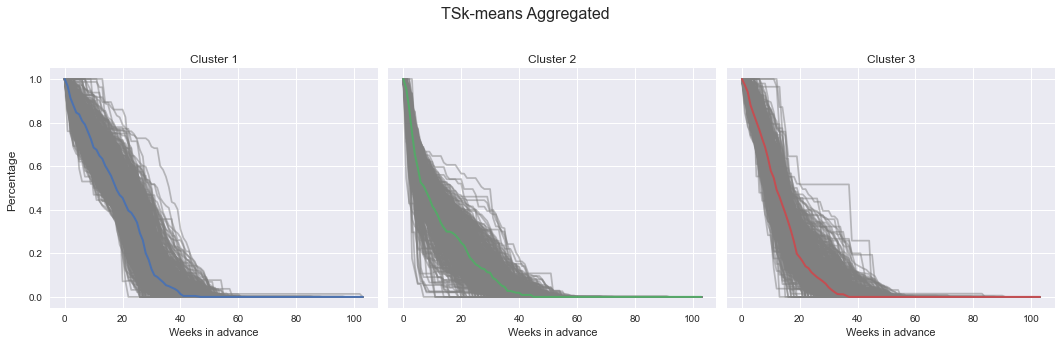

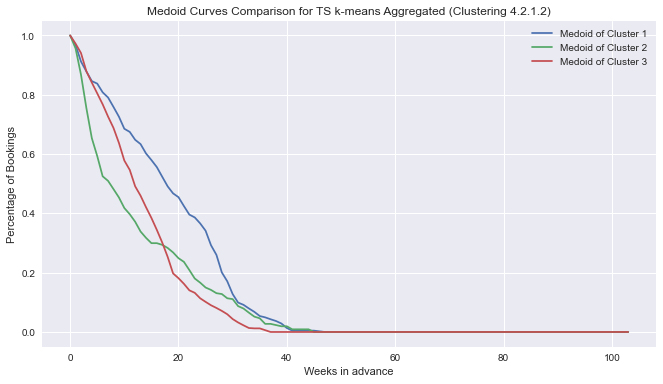

0    662
2    493
1    403
Name: Cluster_per2_TimeSeries, dtype: int64

In [13]:
#Initialize TS k-means aggregated based on the best parameters returned
km_timeseries_per2 = TimeSeriesKMeans(n_clusters=best_params['n_clusters'], metric=best_params['metric'], max_iter=100, random_state=0, n_init=3)

#Create a new column with the cluster labels based on this clustering
X_train_clustering['Cluster_per2_TimeSeries'] = km_timeseries_per2.fit_predict(X_train_clustering_array_per2)

#plot the medoids of this method
plot_medoids(plotting_clusters(X_train_clustering, 'Cluster_per2_TimeSeries', title="TSk-means Aggregated"), "TS k-means Aggregated (Clustering 4.2.1.2)")

#print the value counts per cluster label 
X_train_clustering['Cluster_per2_TimeSeries'].value_counts()

### Feature Clustering (clustering 4.2.2.1)

In [14]:
#Calculate all the features needed (in the non-cumulative curves)

# Serial the first order autocorrelation
def calculate_autocorrelation(data):
    '''
    Calculate the first order autocorrelation coefficient (ACF) of the booking pattern.
    '''
    acf_values = sm.tsa.acf(data, nlags=1)
    return acf_values[1]

def calculate_trend(data):
    '''
    The trend of the booking pattern: calculated as the slope when fitting an OLS regression with a constant in the booking pattern
    '''
    X = np.arange(len(data))
    X = sm.add_constant(X)
    model = sm.OLS(data, X)
    results = model.fit()
    return results.params[1]  # Slope coefficient

def calculate_skewness(data):
    '''
    Calculate the skewness of the booking pattern.
    '''
    return skew(data)

def calculate_kurtosis(data):
    '''
    Calculate the kurtosis of the booking pattern.
    '''
    return kurtosis(data)

def calculate_mean(data):
    '''
    Calculate the mean value of the booking pattern.
    '''
    return np.mean(data)

def calculate_variance(data):
    '''
    Calculate the variance of the booking pattern.
    '''
    return np.var(data)

def calculate_peak_strength(data):
    '''
    Calculate the maximum value of the booking pattern.
    '''
    return np.max(data)


def calculate_trough_depth(data):
    '''
    Calculate the minimum value of the booking pattern. This has to be non-zero.
    '''
    data = np.array(data)
    non_zero_data = data[data != 0]
    return np.min(non_zero_data)

def calculate_spikeiness(data):
    '''
    Calculate the maximum absolute difference between adjacent values in the booking pattern.
    '''
    return np.max(np.abs(np.diff(data)))

#largest level shift or deviation of the data from its smoothed version.
def calculate_level_shift(data, window_size=3):
    '''
    Calculate the maximum deviation of the data of the booking pattern from its rolling mean, with a window size of 3 weeks
    '''
    rolling_mean = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    return np.max(np.abs(data[window_size-1:] - rolling_mean))

def calculate_peak_frequency(data, threshold=0.15):
    '''
    Calculate the number of times the booking pattern exceeded 0.15 (this was seen as a peak)
    '''
    data = np.array(data)
    peaks = np.where(data > threshold)[0]
    return len(peaks)

def calculate_seasonality(df, column_name="BookingsList", period=4):
    '''
    Calculated by decomposing the series into trend, seasonality, and residual. 
    Calculated as the ratio of the variance of seasonality over the summation of the variance of seasonality 
    plus the variance of the residual.
    '''
    seasonality_results = []
    for index, row in df.iterrows():
        data = np.array(row[column_name])
        decomposition = seasonal_decompose(data, model='additive', period=period)
        seasonal_component = decomposition.seasonal
        seasonal_component = seasonal_component[~np.isnan(seasonal_component)]
        residual_component = decomposition.resid
        residual_component = residual_component[~np.isnan(residual_component)]

        # Calculate the variances
        var_seasonal = np.var(seasonal_component)
        var_residual = np.var(residual_component)

        # Calculate the strength of seasonality
        seasonality_strength = var_seasonal / (var_seasonal + var_residual)
        seasonality_results.append(seasonality_strength)
    
    return seasonality_results

# Apply functions to calculate metrics and assign them to DataFrame columns
X_train_clustering["ACF1"] = X_train_clustering["BookingsList"].apply(calculate_autocorrelation)
X_train_clustering["Trend"] = X_train_clustering["BookingsList"].apply(calculate_trend)
X_train_clustering["Skewness"] = X_train_clustering["BookingsList"].apply(calculate_skewness)
X_train_clustering["Kurtosis"] = X_train_clustering["BookingsList"].apply(calculate_kurtosis)
X_train_clustering["Mean"] = X_train_clustering["BookingsList"].apply(calculate_mean)
X_train_clustering["Variance"] = X_train_clustering["BookingsList"].apply(calculate_variance)
X_train_clustering["Peak_Strength"] = X_train_clustering["BookingsList"].apply(calculate_peak_strength)
X_train_clustering["Trough_Depth"] = X_train_clustering["BookingsList"].apply(calculate_trough_depth)
X_train_clustering["Spikeiness"] = X_train_clustering["BookingsList"].apply(calculate_spikeiness)
X_train_clustering["Level_Shift"] = X_train_clustering["BookingsList"].apply(calculate_level_shift)
X_train_clustering["Peak_Frequency"] = X_train_clustering["BookingsList"].apply(calculate_peak_frequency)
X_train_clustering["Seasonality"] = calculate_seasonality(X_train_clustering, 'BookingsList', period=4)


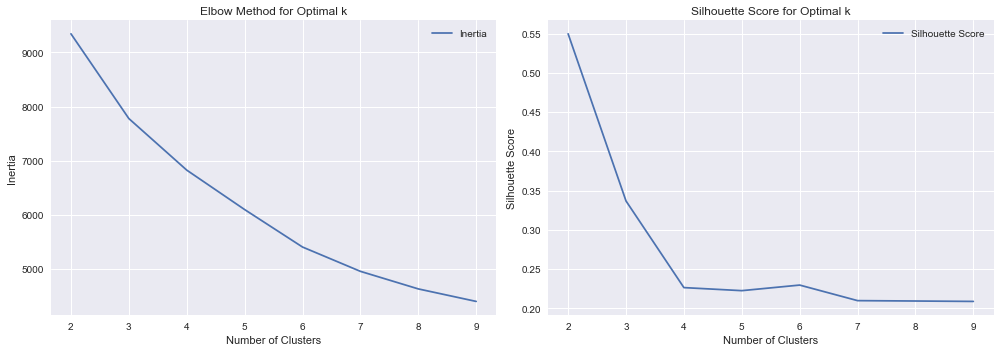

Optimal k: 3


In [15]:
# Select specific features for clustering from avg_curves_clustering DataFrame
features_clustering = X_train_clustering[["ACF1", "Trend", "Skewness", "Kurtosis", "Mean", "Variance", "Peak_Strength", "Trough_Depth", "Spikeiness", "Level_Shift", "Peak_Frequency", "Seasonality"]]

# Standardize the selected features using StandardScaler
scaler = StandardScaler()
features_clustering_scaled = scaler.fit_transform(features_clustering)

# Perform grid search to determine the optimal number of clusters
inertia = []  # List to store inertia values for each k
silhouette_scores = []  # List to store silhouette scores for each k
K = range(2, 10)  # Range of cluster numbers to evaluate (from 2 to 9)

# Iterate through each k and fit KMeans clustering model
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(features_clustering_scaled)
    inertia.append(kmeans.inertia_)  # Append inertia (within-cluster sum of squares) to list
    silhouette_scores.append(silhouette_score(features_clustering_scaled, kmeans.labels_))  # Calculate and append silhouette score

# Create a figure with two subplots: elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot the elbow curve to visualize inertia across different numbers of clusters
axes[0].plot(K, inertia, label='Inertia')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].legend()

# Plot the silhouette scores to evaluate clustering quality
axes[1].plot(K, silhouette_scores, label='Silhouette Score')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score for Optimal k')
axes[1].legend()

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

# Determine the optimal number of clusters based on silhouette score
silhouette_scores_3_plus = silhouette_scores[1:]  # Exclude silhouette score for k=2
optimal_k = K[np.argmax(silhouette_scores_3_plus) + 1]  # Find index of maximum score and adjust for 0-based index
print(f"Optimal k: {optimal_k}")  # Print the optimal number of clusters


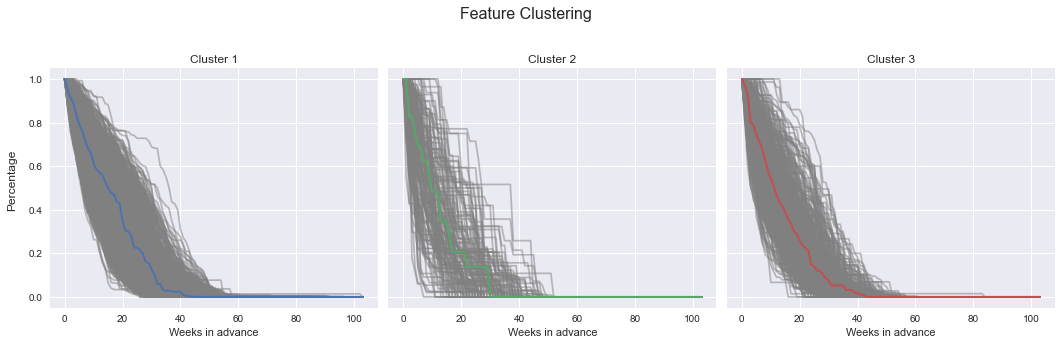

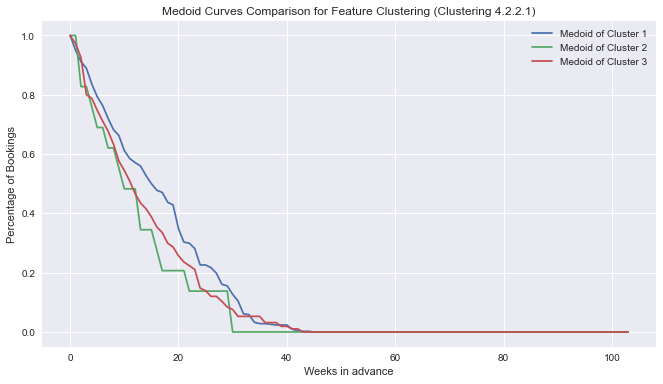

0    1060
2     361
1     137
Name: Cluster_features, dtype: int64

In [16]:
#Initialize Feature Clustering based on best parameters given
kmeans_features = KMeans(n_clusters=optimal_k, random_state=0)

#Create a new column with the cluster labels based on this clustering
X_train_clustering['Cluster_features'] = kmeans_features.fit_predict(features_clustering_scaled)

#plot the medoids of this method
plot_medoids(plotting_clusters(X_train_clustering, "Cluster_features", title="Feature Clustering"), "Feature Clustering (Clustering 4.2.2.1)")

#print the value counts per cluster label 
X_train_clustering['Cluster_features'].value_counts()

# Understand Clustering

### ARI results

In [17]:
# Select columns wirh cluster labels for comparison
cluster_assignments = X_train_clustering[["Cluster_TimeSeries", "Cluster_per2_TimeSeries", "Cluster_features"]]

# List to store Adjusted Rand Index (ARI) results for each column pair comparison
ari_results = []

# Generate all combinations of column pairs for comparison
column_pairs = list(combinations(cluster_assignments.columns, 2))

# Iterate through each pair of columns
for pair in column_pairs:
    clustering1 = cluster_assignments[pair[0]]  # First clustering result from the pair
    clustering2 = cluster_assignments[pair[1]]  # Second clustering result from the pair
    
    # Calculate Adjusted Rand Index (ARI) between the two clusterings
    ari = adjusted_rand_score(clustering1, clustering2)
    
    # Append the column names and corresponding ARI to results list
    ari_results.append((pair[0], pair[1], ari))

# Print the results of ARI comparisons
print("Adjusted Rand Index (ARI):")
for result in ari_results:
    print(f"{result[0]} vs {result[1]}: {result[2]}")

Adjusted Rand Index (ARI):
Cluster_TimeSeries vs Cluster_per2_TimeSeries: 0.2129217587380906
Cluster_TimeSeries vs Cluster_features: 0.3371830673678754
Cluster_per2_TimeSeries vs Cluster_features: 0.07566929655359401


### Understand characteristics of each cluster 

In [18]:
# Select relevant columns from X_train_clustering for analysis
data_cluster = X_train_clustering[["Cluster_TimeSeries", "Cluster_per2_TimeSeries", "Cluster_features", "DepartureWeek", "DestinationAirport", "DestinationCountry"]]

In [19]:
# Define the mapping of departure weeks to bins and labels
# This was done following Figure 5.2
departure_week_mapping = [
        ([51, 52, 1], "6"),
        ([2, 3, 4, 5], "8"),
        ([6, 7, 8, 9], "7"),
        ([10, 11, 12, 13, 14, 15, 16], "5"),
        ([17, 18, 19], "8"),
        ([20, 21, 22, 23, 24], "3"),
        ([25, 26, 27, 28], "2"),
        ([29, 30, 31, 32, 33, 34], "1"),
        ([35, 36, 37, 38, 39, 40, 41, 42], "4"),
        ([43, 44, 45], "7"),
        ([46, 47, 48, 49], "5"),
        ([50, 51, 52], "8")
    ]

 # Convert the list of mappings into a dictionary
departure_week_mapping_dict = {}
for week_numbers, label in departure_week_mapping:
    for week in week_numbers:
        departure_week_mapping_dict[week] = label

#Assign value to "GroupedDepartureWeek"
data_cluster["GroupedDepartureWeek"] = data_cluster["DepartureWeek"].map(departure_week_mapping_dict)


In [20]:
def plot_cluster_distribution_by_destination(data, cluster_column, ax):
    """
    Plot normalized distribution of clusters by destination country.

    Parameters:
    - data: DataFrame containing columns with cluster assignments and destination country 
    - cluster_column: Column name for cluster labels
    - ax: Matplotlib axis object where the plot will be drawn.
    """
    
    # Select relevant columns from data for analysis
    data_cluster_country = data[[cluster_column, "DestinationCountry"]]

    # Group by DestinationCountry and cluster_column, count occurrences, and fill NaN values with 0
    country_cluster_dist = data_cluster_country.groupby(['DestinationCountry', cluster_column]).size().unstack().fillna(0)

    # Normalize the distribution of clusters by dividing each row by its sum
    country_cluster_norm = country_cluster_dist.div(country_cluster_dist.sum(axis=1), axis=0)

    # Plot a stacked horizontal bar chart from the normalized data
    country_cluster_norm.plot(kind='barh', stacked=True, ax=ax)
    ax.set_title(f'Normalized Distribution of Clusters by {cluster_column}')
    ax.set_ylabel("Destination Country")

    # Get handles and labels from the plot
    handles, labels = ax.get_legend_handles_labels()

    # Generate new labels for the legend (increment cluster numbers by 1)
    new_labels = [f'Cluster {int(label)+1}' for label in labels]

    # Move the legend to the upper left outside the plot area
    ax.legend(handles, new_labels, bbox_to_anchor=(1.05, 1), loc='upper left')


In [21]:
def plot_cluster_distribution_by_week(data, cluster_column, ax):
    """
    Plot normalized distribution of clusters by grouped departure weeks.

    Parameters:
    - data: DataFrame containing columns with cluster assignments and departure weeks 
    - cluster_column: Column name for cluster labels
    - ax: Matplotlib axis object where the plot will be drawn.
    """
    
    # Select relevant columns from data for analysis
    data_cluster_depweek = data[[cluster_column, "GroupedDepartureWeek"]]
    
    # Calculate normalized distribution of clusters by aggregated departure week
    week_cluster_dist = data_cluster_depweek.groupby(["GroupedDepartureWeek", cluster_column]).size().unstack().fillna(0)
    week_cluster_norm = week_cluster_dist.div(week_cluster_dist.sum(axis=1), axis=0)

    # Plot a stacked horizontal bar chart from the normalized data
    week_cluster_norm.plot(kind='barh', stacked=True, ax=ax)
    ax.set_title('Normalized Distribution of Clusters by Grouped Departure Week')
    ax.set_ylabel("Grouped Departure Weeks")

    # Get handles and labels from the plot
    handles, labels = ax.get_legend_handles_labels()

    # Generate new labels for the legend (increment cluster numbers by 1)
    new_labels = [f'Cluster {int(label)+1}' for label in labels]
    
    # Move the legend to the upper left outside the plot area
    ax.legend(handles, new_labels, bbox_to_anchor=(1.05, 1), loc='upper left')


In [22]:
def plot_feature_importance(data, cluster_column):
    """
    Plot feature importances using RandomForestClassifier: to understand if destination country or grouped departure week 
    play a more important role 

    Parameters:
    - data: DataFrame containing columns 'DestinationCountry', 'GroupedDepartureWeek' and clustering labels
    - cluster_column: Column name for clustering information.
    """
    # Encode categorical features

    # Initialize LabelEncoder for 'DestinationCountry'
    lecountry = LabelEncoder()
    data['Country_Encoded'] = lecountry.fit_transform(data['DestinationCountry'])

    # Ensure 'GroupedDepartureWeek' is string type before encoding
    data["GroupedDepartureWeek"] = data["GroupedDepartureWeek"].astype(str)
    
    # Initialize LabelEncoder for 'GroupedDepartureWeek'
    leweek = LabelEncoder()
    data["Week_Encoded"] = leweek.fit_transform(data["GroupedDepartureWeek"])

    # Prepare features and labels
    # Select encoded features for training
    features = data[['Country_Encoded', 'Week_Encoded']]
    # Select labels (target variable)
    labels = data[cluster_column]


    # Initialize RandomForestClassifier with a random state for reproducibility
    random_forest = RandomForestClassifier(random_state=0)
    
    # Fit the classifier with features and labels
    random_forest.fit(features, labels)

    # Retrieve feature importances from the trained classifier
    importances = random_forest.feature_importances_
    # Define feature names for plotting purposes
    feature_names = ['DestinationCountry', 'GroupedDepartureWeek']

    # Plot overall feature importances

    # Create a horizontal bar plot to visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importances)
    plt.title('Feature Importance: Overall')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

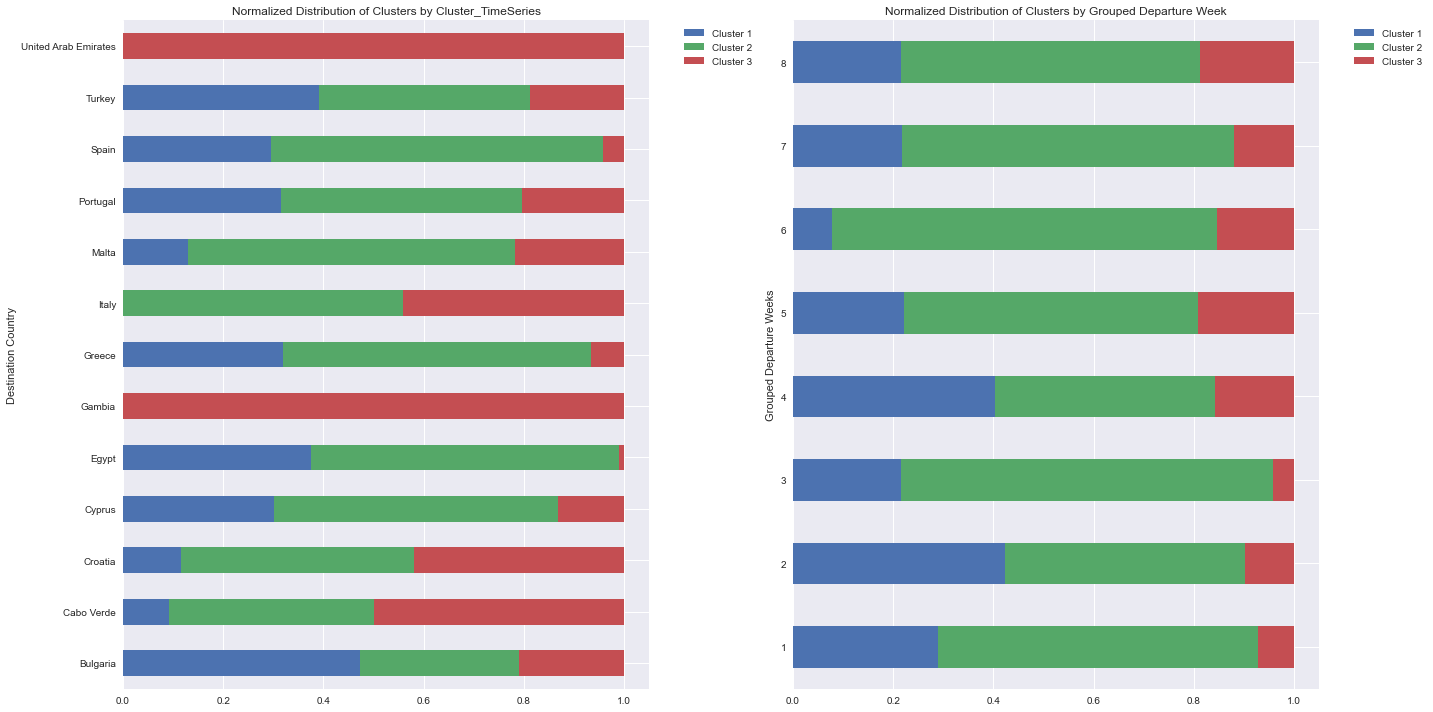

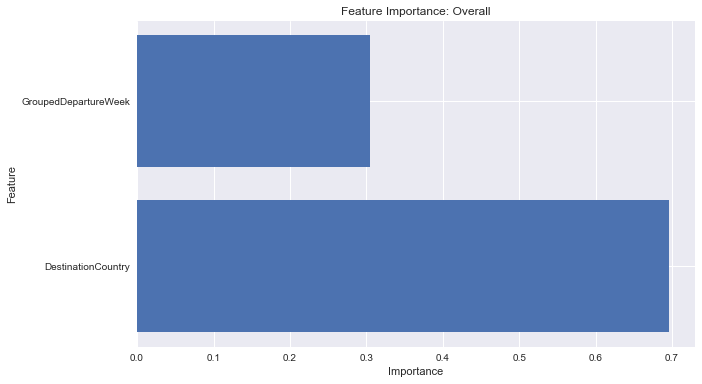

In [23]:
# Example usage for clustering 4.2.1.1
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# Plot the distribution by destination in the first subplot
plot_cluster_distribution_by_destination(data_cluster, 'Cluster_TimeSeries', axs[0])

# Plot the distribution by week in the second subplot
plot_cluster_distribution_by_week(data_cluster, 'Cluster_TimeSeries', axs[1])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

plot_feature_importance(data_cluster, 'Cluster_TimeSeries')

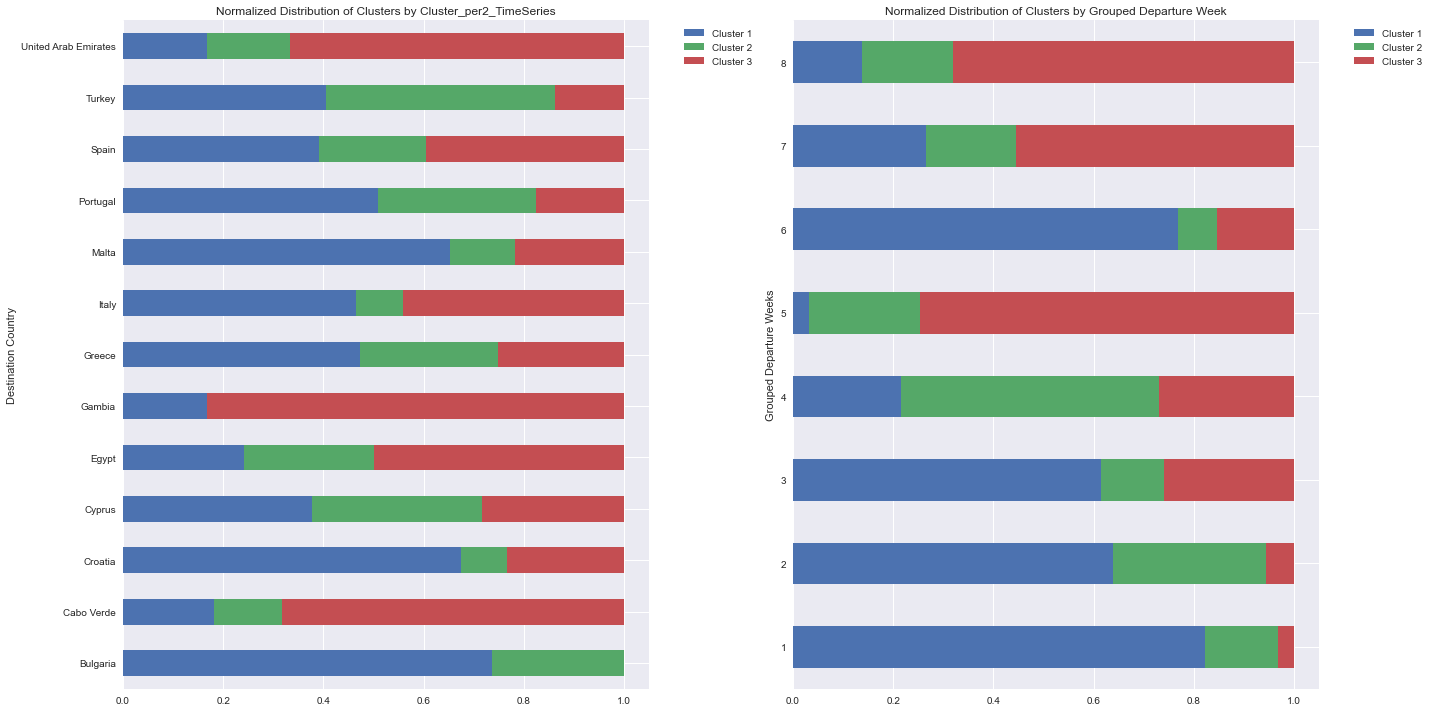

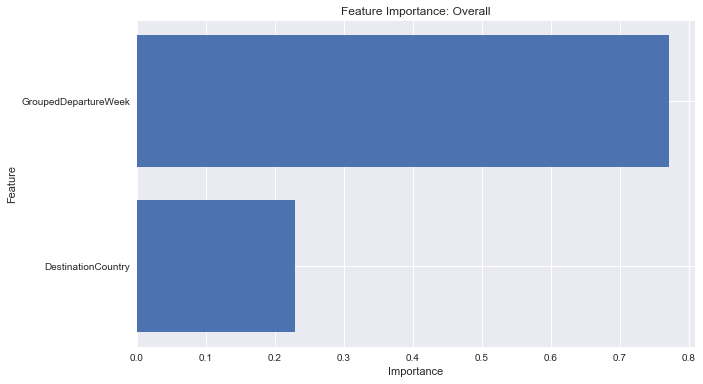

In [24]:
#Analogous analysis can be done for all three clustering methods by changing the column where the cluster labels are stored

# Example usage for clustering 4.2.1.2
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
plot_cluster_distribution_by_destination(data_cluster, "Cluster_per2_TimeSeries", axs[0])
plot_cluster_distribution_by_week(data_cluster, "Cluster_per2_TimeSeries", axs[1])
plt.tight_layout()
plt.show()

plot_feature_importance(data_cluster, "Cluster_per2_TimeSeries")

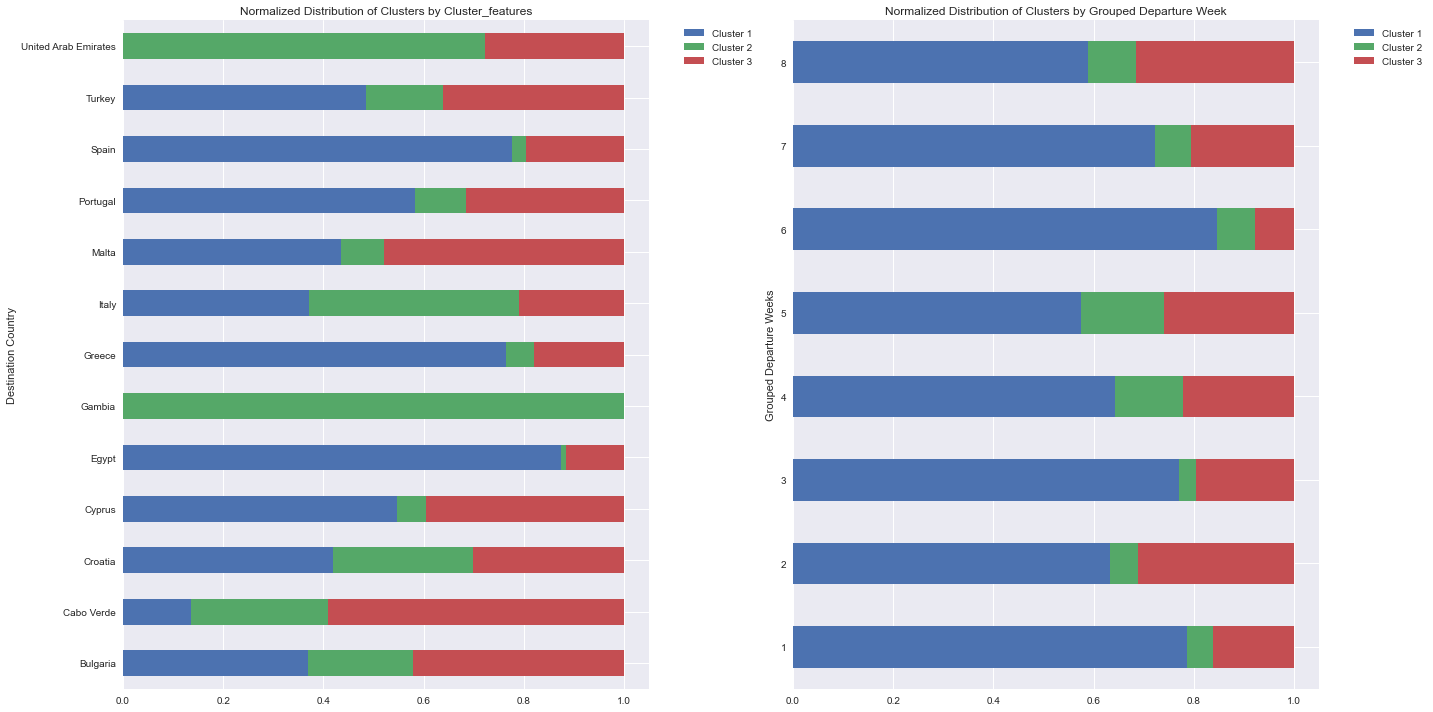

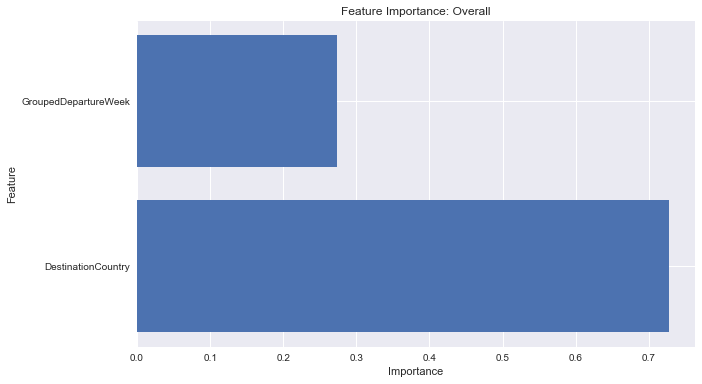

In [25]:
# Example usage for clustering 4.2.2.1
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
plot_cluster_distribution_by_destination(data_cluster, "Cluster_features", axs[0] )
plot_cluster_distribution_by_week(data_cluster, "Cluster_features", axs[1])
plt.tight_layout()
plt.show()

plot_feature_importance(data_cluster, "Cluster_features")